In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from matplotlib import cm
import pygmt

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src import plotting
from src.utils import combine_prediction_files, compute_network_avg_prediction

In [2]:
magdir = '/uufs/chpc.utah.edu/common/home/koper-group3/alysha/magnitudes'
p_resultsdir = os.path.join(magdir, 'p_models')
s_resultsdir = os.path.join(magdir, 's_models')
selectedfeatdir = "selected_features_constHP"

p_test_df = pd.read_csv(os.path.join(magdir, 'feature_splits', 'p.test.csv'))
p_2023_df = pd.read_csv(os.path.join(magdir, 'feature_splits','p.20230101.csv'))
s_test_df = pd.read_csv(os.path.join(magdir, 'feature_splits','s.test.csv'))
s_2023_df = pd.read_csv(os.path.join(magdir, 'feature_splits','s.20230101.csv'))
p_train_df = pd.read_csv(os.path.join(magdir, 'feature_splits', 'p.train.csv'))
s_train_df = pd.read_csv(os.path.join(magdir, 'feature_splits','s.train.csv'))

p_stats = p_test_df.station.unique()
p_test_preds = combine_prediction_files(p_stats,
                                            os.path.join(p_resultsdir, selectedfeatdir),
                                            'P',
                                            'test')

p_2023_preds = combine_prediction_files(p_stats,
                                            os.path.join(p_resultsdir, selectedfeatdir),
                                            'P',
                                            'holdout')

s_stats = s_test_df.station.unique()
s_test_preds = combine_prediction_files(s_stats,
                                            os.path.join(s_resultsdir, selectedfeatdir),
                                            'S',
                                            'test')

s_2023_preds = combine_prediction_files(s_stats,
                                            os.path.join(s_resultsdir, selectedfeatdir),
                                            'S',
                                            'holdout')

/uufs/chpc.utah.edu/common/home/koper-group3/alysha/magnitudes/p_models/selected_features_constHP/B207.P.preds.holdout.csv does not exist, skipping...
/uufs/chpc.utah.edu/common/home/koper-group3/alysha/magnitudes/p_models/selected_features_constHP/H17A.P.preds.holdout.csv does not exist, skipping...
/uufs/chpc.utah.edu/common/home/koper-group3/alysha/magnitudes/p_models/selected_features_constHP/B208.P.preds.holdout.csv does not exist, skipping...
/uufs/chpc.utah.edu/common/home/koper-group3/alysha/magnitudes/p_models/selected_features_constHP/B944.P.preds.holdout.csv does not exist, skipping...
/uufs/chpc.utah.edu/common/home/koper-group3/alysha/magnitudes/p_models/selected_features_constHP/B206.P.preds.holdout.csv does not exist, skipping...
/uufs/chpc.utah.edu/common/home/koper-group3/alysha/magnitudes/p_models/selected_features_constHP/B950.P.preds.holdout.csv does not exist, skipping...
/uufs/chpc.utah.edu/common/home/koper-group3/alysha/magnitudes/s_models/selected_features_cons

In [3]:
def get_residuals(df):
    return df['magnitude'] - df['predicted_magnitude']

In [4]:
p_test_preds['residual'] = get_residuals(p_test_preds)
p_2023_preds['residual'] = get_residuals(p_2023_preds)
s_test_preds['residual'] = get_residuals(s_test_preds)
s_2023_preds['residual'] = get_residuals(s_2023_preds)

In [5]:
p_test_preds.head()

,Evid,magnitude,predicted_magnitude,station,residual
0,60001357,2.096191,1.888076,YPP,0.208114
1,60001372,2.519942,2.066855,YPP,0.453087
2,60001382,3.094789,3.082749,YPP,0.012040
3,60002142,2.352687,2.092923,YPP,0.259765
4,60004552,2.102261,2.188987,YPP,-0.086726


In [6]:
p_test_preds = p_test_preds.merge(p_test_df.drop_duplicates('Evid')[['Evid', 'source_longitude', 'source_latitude']], how='left')
p_2023_preds = p_2023_preds.merge(p_2023_df.drop_duplicates('Evid')[['Evid', 'source_longitude', 'source_latitude']], how='left')
s_test_preds = s_test_preds.merge(s_test_df.drop_duplicates('Evid')[['Evid', 'source_longitude', 'source_latitude']], how='left')
s_2023_preds = s_2023_preds.merge(s_2023_df.drop_duplicates('Evid')[['Evid', 'source_longitude', 'source_latitude']], how='left')

p_test_preds = p_test_preds.iloc[np.argsort(abs(p_test_preds.residual).values)]
p_2023_preds = p_2023_preds.iloc[np.argsort(abs(p_2023_preds.residual).values)]
s_test_preds = s_test_preds.iloc[np.argsort(abs(s_test_preds.residual).values)]
s_2023_preds = s_2023_preds.iloc[np.argsort(abs(s_2023_preds.residual).values)]

In [7]:
p_combined_preds= pd.concat([p_test_preds, p_2023_preds])
p_combined_preds = p_combined_preds.iloc[np.argsort(abs(p_combined_preds.residual).values)]
s_combined_preds= pd.concat([s_test_preds, s_2023_preds])
s_combined_preds = s_combined_preds.iloc[np.argsort(abs(s_combined_preds.residual).values)]

In [8]:
summfilename = 'all.stat.results.csv'
p_results = pd.read_csv(os.path.join(p_resultsdir, selectedfeatdir, summfilename))
s_results = pd.read_csv(os.path.join(s_resultsdir, selectedfeatdir, summfilename))

In [9]:
# Read in park and caldera boundaries
utahnetdir = '../data/utahnet'

ys_border = pd.read_csv(os.path.join(utahnetdir, 'yell.border.g'), delimiter=" ", names=["Longitude", "Latitude"], dtype=np.float64)
caldera = pd.read_csv(os.path.join(utahnetdir, 'caldera.ys'), sep="\s+", names=["Latitude", "Longitude"], dtype=np.float64)

caldera = caldera.drop(caldera[caldera["Longitude"]==0].index)
caldera = caldera[["Longitude", "Latitude"]]
caldera["Longitude"] = caldera["Longitude"]*-1
caldera.head()

,Longitude,Latitude
0,-110.6149,44.7057
1,-110.6154,44.7040
2,-110.6158,44.7023
3,-110.6162,44.7003
4,-110.6158,44.6986


In [10]:
p_train_ev_df = p_train_df.drop_duplicates('Evid')

makecpt [WARNING]: Without inc in -T option, -Z has no effect (ignored)


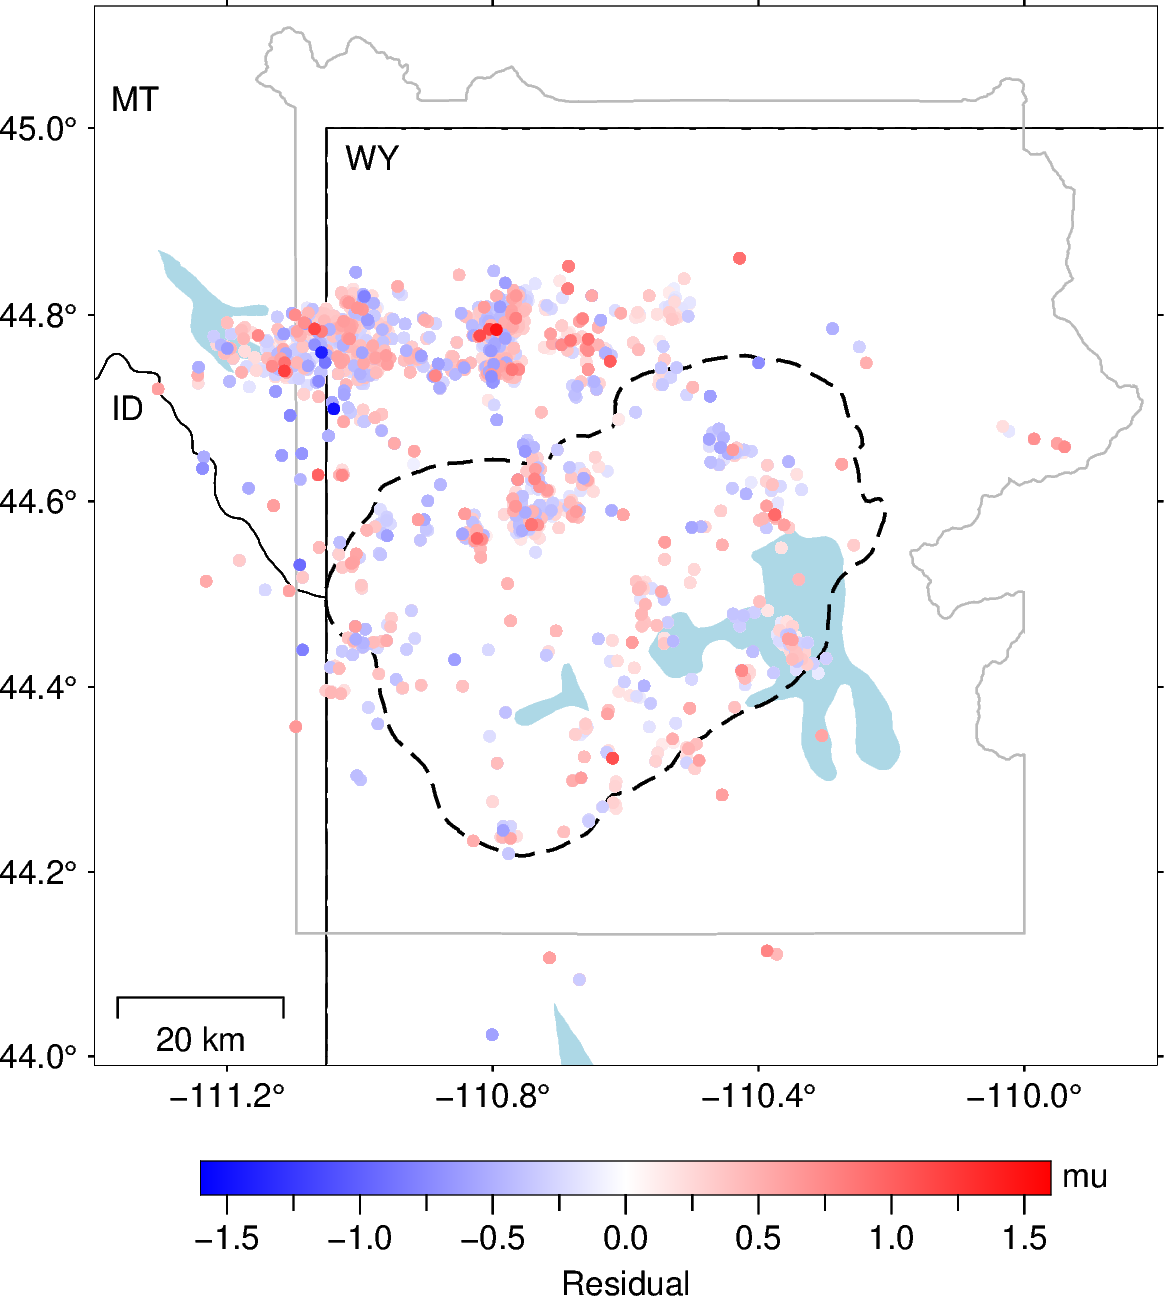

In [11]:
fig = pygmt.Figure()
pygmt.config(FORMAT_GEO_MAP="ddd.x")
pygmt.config(FONT="8p")

STUDYREG = np.array([-111.40, -109.80, 43.99, 45.13])
#STUDYREG = np.array([-111.50, -109.80, 43.99, 45.13])
projection = f"M5.4/9"


with pygmt.config(MAP_FRAME_TYPE="plain", MAP_FRAME_PEN="0.15p", MAP_TICK_LENGTH_PRIMARY="0.05c", 
                 FONT_TITLE="5p"):
    fig.coast(region=STUDYREG, projection=projection, water="lightblue", borders="2/0.3p")

    fig.basemap(region=STUDYREG, projection=projection, frame=["SenW+t", "xa0.4", "ya0.2"], 
               map_scale="jBL+w20k+o0.2c/0.4c")

#
# Plot utahnet boundaries
#
fig.plot(data=ys_border, pen='0.5p,#bababa')
fig.plot(data=caldera, pen='0.75p,black,-')

#
# State and feature labels
#
fig.text(x=-111.375, y=45.0, text="MT", offset="0.0/0.25", justify="LM")
fig.text(x=-111.2, y=45.0, text="WY", offset="1.00/-0.25", justify="LM")
fig.text(x=-111.375, y=44.7, text="ID", justify="LM")

#
# Plot events
#
pygmt.makecpt(cmap="polar", series=[-1.6, 1.6],
                continuous=True)
stat_df = p_test_preds
fig.plot(x=stat_df.source_longitude, y=stat_df.source_latitude,
        style='c0.1c', fill=stat_df.residual, cmap=True)
# fig.plot(data=p_train_df[['source_longitude', 'source_latitude']], style='c0.5p', fill='black')

fig.colorbar(frame=["xa0.5f0.25+lResidual", "y+lmu"])
fig.show()

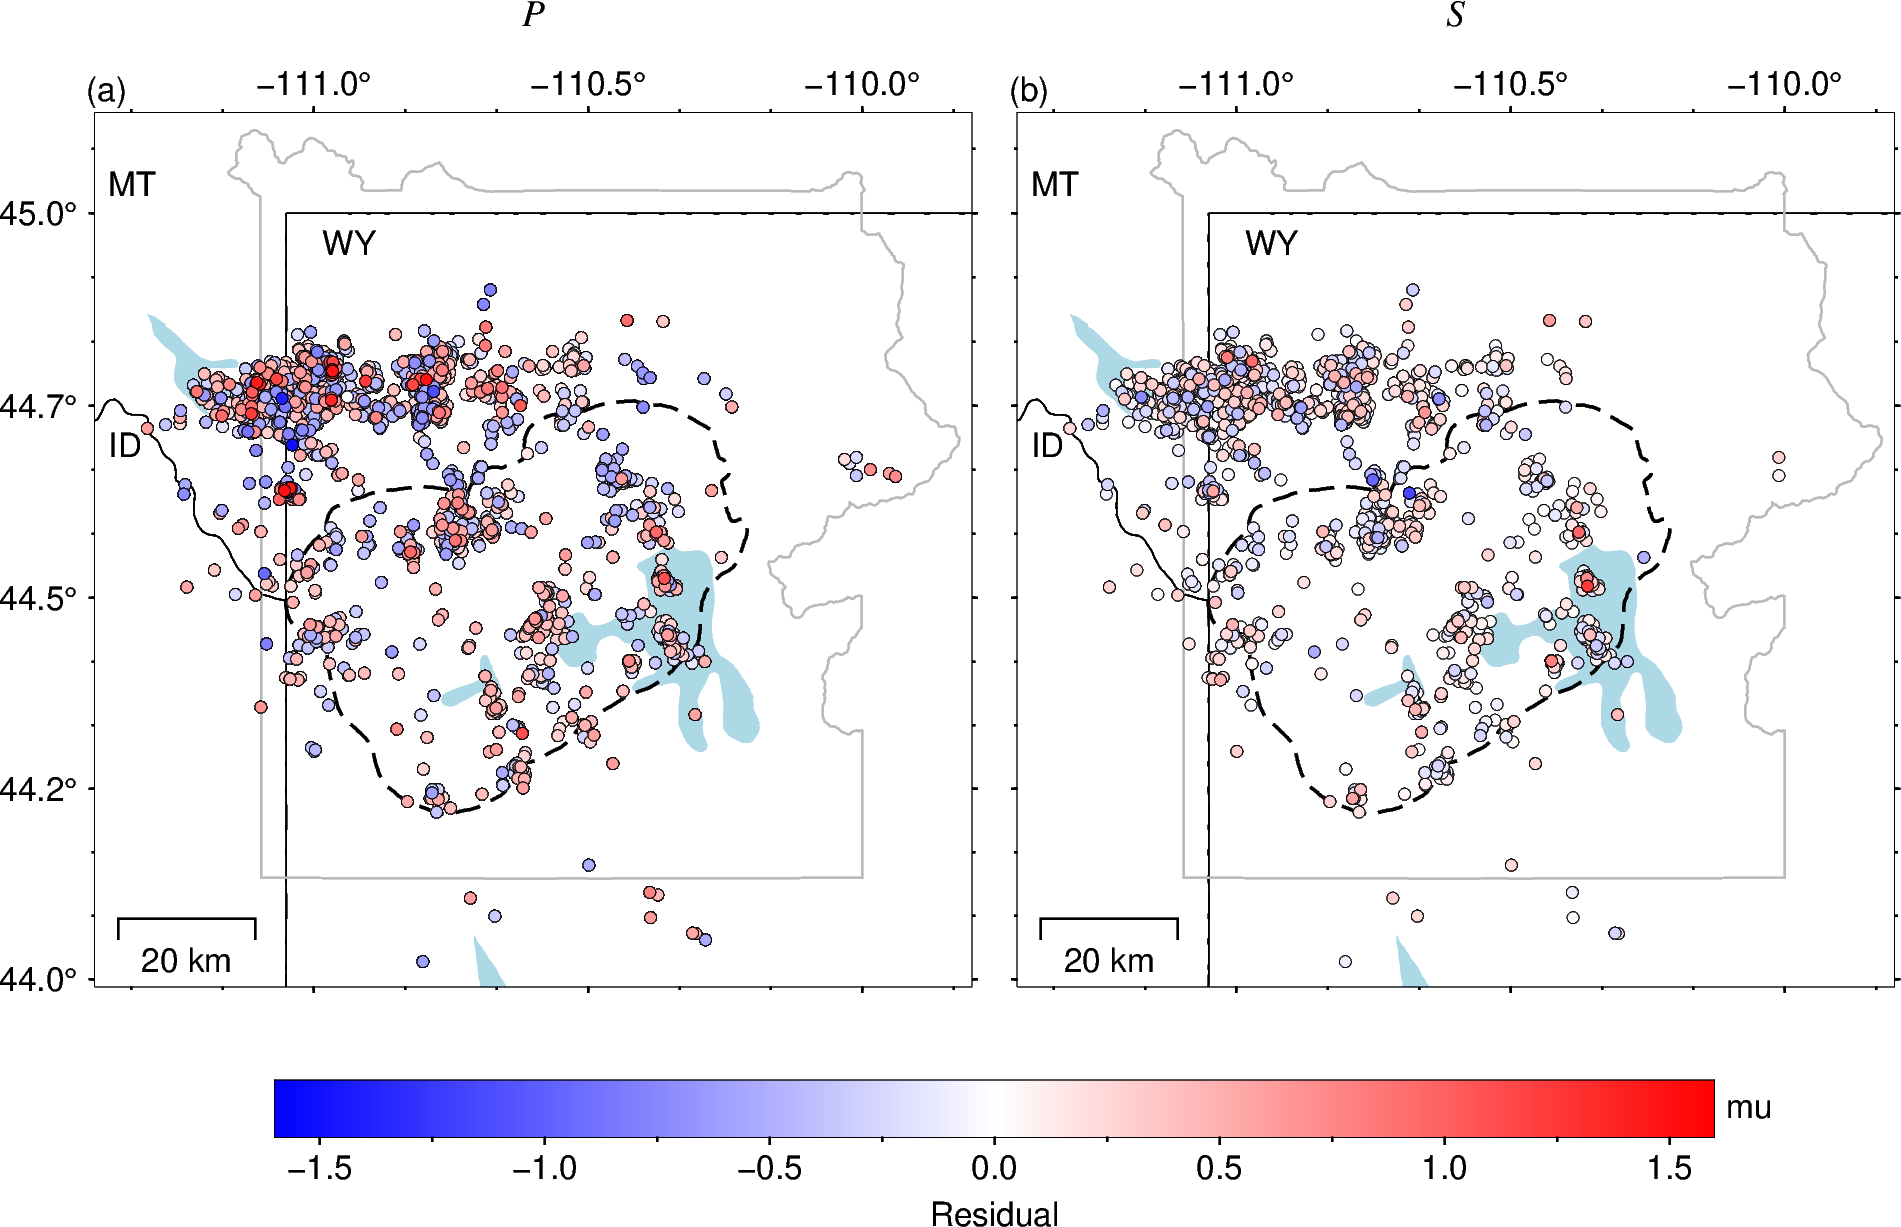

In [12]:
fig = pygmt.Figure()
pygmt.config(FORMAT_GEO_MAP="ddd.x")
pygmt.config(FONT="8p")
pygmt.config(MAP_FRAME_TYPE="plain", MAP_FRAME_PEN="0.15p", MAP_TICK_LENGTH_PRIMARY="0.05c", 
                 FONT_TITLE="9p")
                 
STUDYREG = np.array([-111.40, -109.80, 43.99, 45.13])
#STUDYREG = np.array([-111.50, -109.80, 43.99, 45.13])
projection = f"M?"
pygmt.makecpt(cmap="polar", series=[-1.6, 1.6])
phases = ["P", "S"]
labels=["(a)", "(b)"]
with fig.subplot(ncols=2, figsize=("6i", "3i"), sharey='l', sharex='t'):
    for i, stat_df in enumerate([p_combined_preds, s_combined_preds]):
        phase = phases[i]
        fig.coast(region=STUDYREG, projection=projection, water="lightblue", borders="2/0.3p", panel=True)

        fig.basemap(region=STUDYREG, projection=projection, 
                map_scale="jBL+w20k+o0.2c/0.4c", frame=f"+t@%Times-Italic%{phase}@%%")
        #
        # Plot utahnet boundaries
        #
        fig.plot(data=ys_border, pen='0.5p,#bababa')
        fig.plot(data=caldera, pen='0.75p,black,-')
        fig.text(x=STUDYREG[0], y=STUDYREG[-1], offset="0.1c/0.2c", text=labels[i], no_clip=True)
        #
        # State and feature labels
        #
        fig.text(x=-111.375, y=45.0, text="MT", offset="0.0/0.25", justify="LM")
        fig.text(x=-111.2, y=45.0, text="WY", offset="1.00/-0.25", justify="LM")
        fig.text(x=-111.375, y=44.7, text="ID", justify="LM")

        #
        # Plot events
        #
        fig.plot(x=stat_df.source_longitude, y=stat_df.source_latitude,
                style='c0.1c', fill=stat_df.residual, cmap=True, pen='0.1p,black')

# fig.plot(data=p_train_df[['source_longitude', 'source_latitude']], style='c0.5p', fill='black')

fig.colorbar(frame=["xa0.5f0.25+lResidual", "y+lmu"])
fig.show()

makecpt [WARNING]: Without inc in -T option, -Z has no effect (ignored)


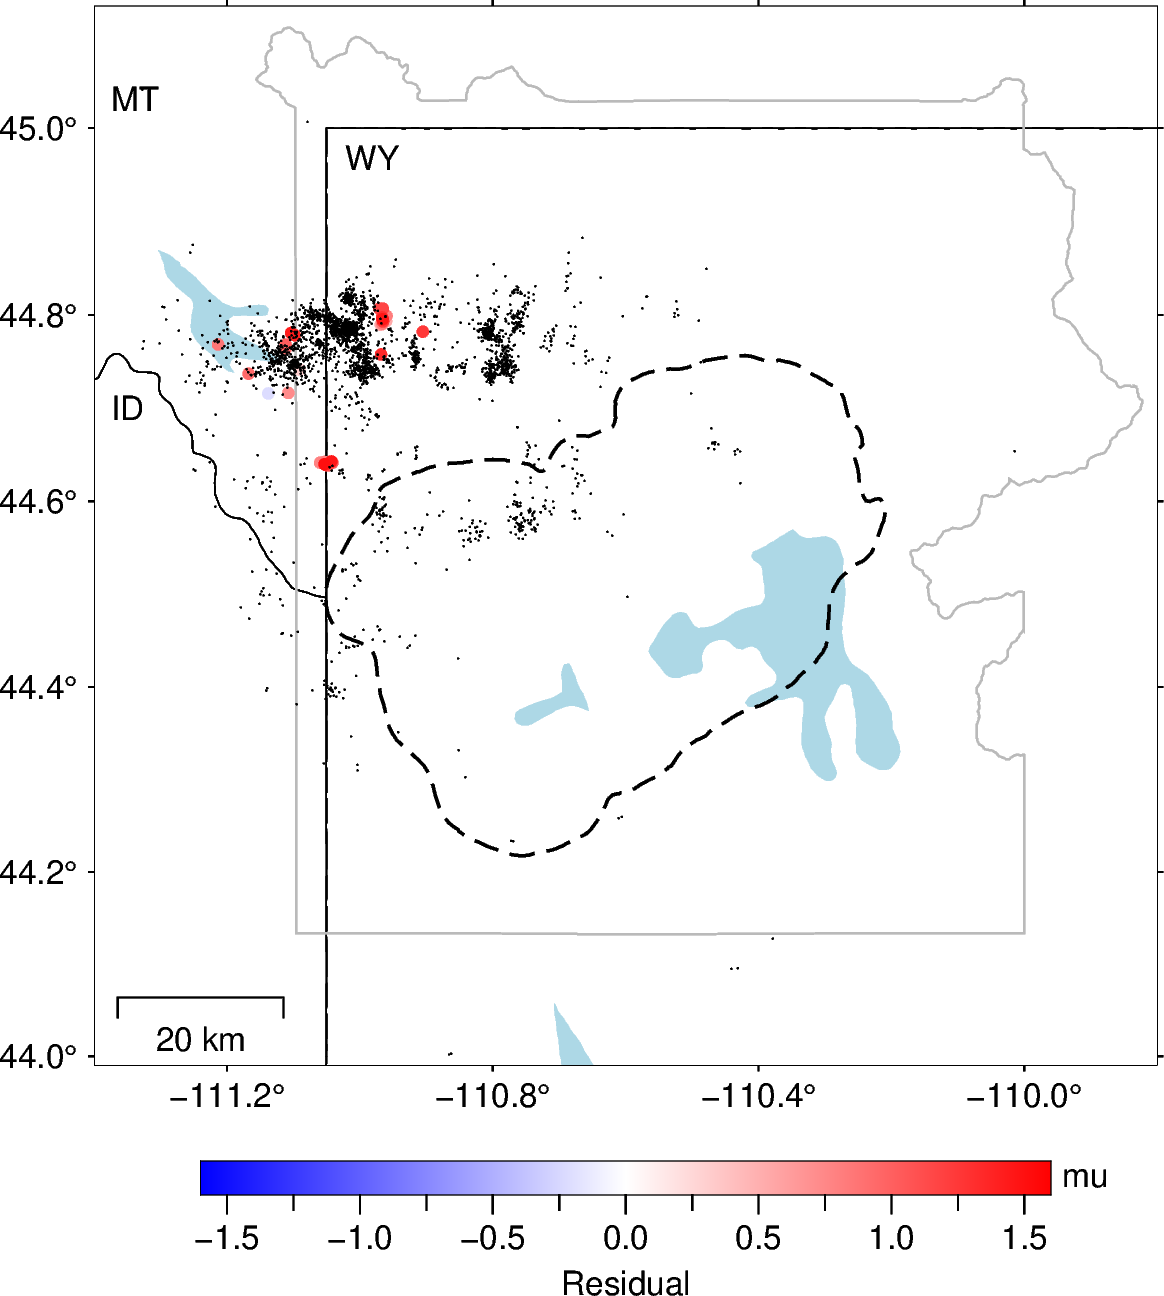

In [13]:
fig = pygmt.Figure()
pygmt.config(FORMAT_GEO_MAP="ddd.x")
pygmt.config(FONT="8p")

STUDYREG = np.array([-111.40, -109.80, 43.99, 45.13])
#STUDYREG = np.array([-111.50, -109.80, 43.99, 45.13])
projection = f"M5.4/9"


with pygmt.config(MAP_FRAME_TYPE="plain", MAP_FRAME_PEN="0.15p", MAP_TICK_LENGTH_PRIMARY="0.05c", 
                 FONT_TITLE="5p"):
    fig.coast(region=STUDYREG, projection=projection, water="lightblue", borders="2/0.3p")

    fig.basemap(region=STUDYREG, projection=projection, frame=["SenW+t", "xa0.4", "ya0.2"], 
               map_scale="jBL+w20k+o0.2c/0.4c")

#
# Plot utahnet boundaries
#
fig.plot(data=ys_border, pen='0.5p,#bababa')
fig.plot(data=caldera, pen='0.75p,black,-')

#
# State and feature labels
#
fig.text(x=-111.375, y=45.0, text="MT", offset="0.0/0.25", justify="LM")
fig.text(x=-111.2, y=45.0, text="WY", offset="1.00/-0.25", justify="LM")
fig.text(x=-111.375, y=44.7, text="ID", justify="LM")

#
# Plot events
#
pygmt.makecpt(cmap="polar", series=[-1.6, 1.6],
                continuous=True)
stat_df = p_2023_preds[p_2023_preds.station == 'YDC']
fig.plot(x=stat_df.source_longitude, y=stat_df.source_latitude,
        style='c0.1c', fill=stat_df.residual, cmap=True)
fig.plot(data=p_train_df[p_train_df.station == 'YDC'][['source_longitude', 'source_latitude']], style='c0.5p', fill='black')

fig.colorbar(frame=["xa0.5f0.25+lResidual", "y+lmu"])
fig.show()

makecpt [WARNING]: Without inc in -T option, -Z has no effect (ignored)


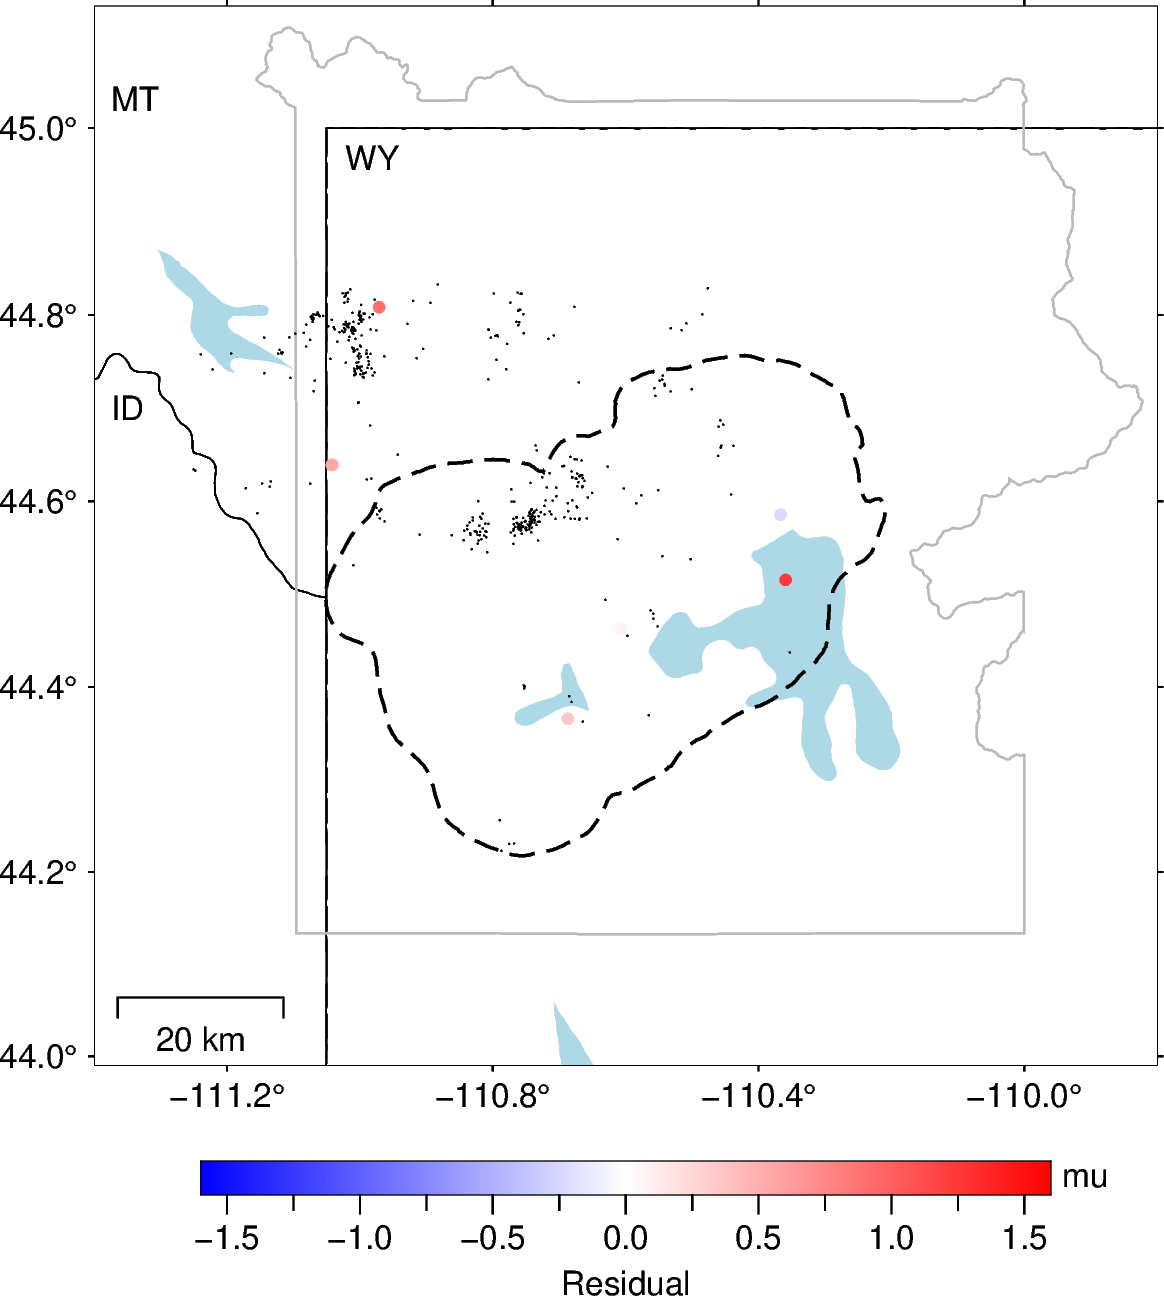

In [14]:
fig = pygmt.Figure()
pygmt.config(FORMAT_GEO_MAP="ddd.x")
pygmt.config(FONT="8p")

STUDYREG = np.array([-111.40, -109.80, 43.99, 45.13])
#STUDYREG = np.array([-111.50, -109.80, 43.99, 45.13])
projection = f"M5.4/9"


with pygmt.config(MAP_FRAME_TYPE="plain", MAP_FRAME_PEN="0.15p", MAP_TICK_LENGTH_PRIMARY="0.05c", 
                 FONT_TITLE="5p"):
    fig.coast(region=STUDYREG, projection=projection, water="lightblue", borders="2/0.3p")

    fig.basemap(region=STUDYREG, projection=projection, frame=["SenW+t", "xa0.4", "ya0.2"], 
               map_scale="jBL+w20k+o0.2c/0.4c")

#
# Plot utahnet boundaries
#
fig.plot(data=ys_border, pen='0.5p,#bababa')
fig.plot(data=caldera, pen='0.75p,black,-')

#
# State and feature labels
#
fig.text(x=-111.375, y=45.0, text="MT", offset="0.0/0.25", justify="LM")
fig.text(x=-111.2, y=45.0, text="WY", offset="1.00/-0.25", justify="LM")
fig.text(x=-111.375, y=44.7, text="ID", justify="LM")

#
# Plot events
#
pygmt.makecpt(cmap="polar", series=[-1.6, 1.6],
                continuous=True)
stat_df = s_2023_preds[s_2023_preds.station == 'YML']
fig.plot(x=stat_df.source_longitude, y=stat_df.source_latitude,
        style='c0.1c', fill=stat_df.residual, cmap=True)
fig.plot(data=s_train_df[s_train_df.station == 'YML'][['source_longitude', 'source_latitude']], style='c0.5p', fill='black')

fig.colorbar(frame=["xa0.5f0.25+lResidual", "y+lmu"])
fig.show()

In [15]:
p_test_preds.groupby('station')

In [16]:
p_results[p_results['test_r2'] < 0.85]

,train_r2,train_rmse,test_r2,test_rmse,holdout_r2,holdout_rmse,station,phase
1,0.817,0.241,0.766,0.274,-3.866,1.079,YDC,P
12,0.911,0.182,0.831,0.226,NaN,NaN,B208,P
14,0.877,0.190,0.849,0.222,0.700,0.193,FLWY,P
16,0.861,0.215,0.839,0.231,0.891,0.196,YMC,P
20,0.844,0.231,0.819,0.242,NaN,NaN,B944,P


YDC
B208
FLWY
YMC
B944


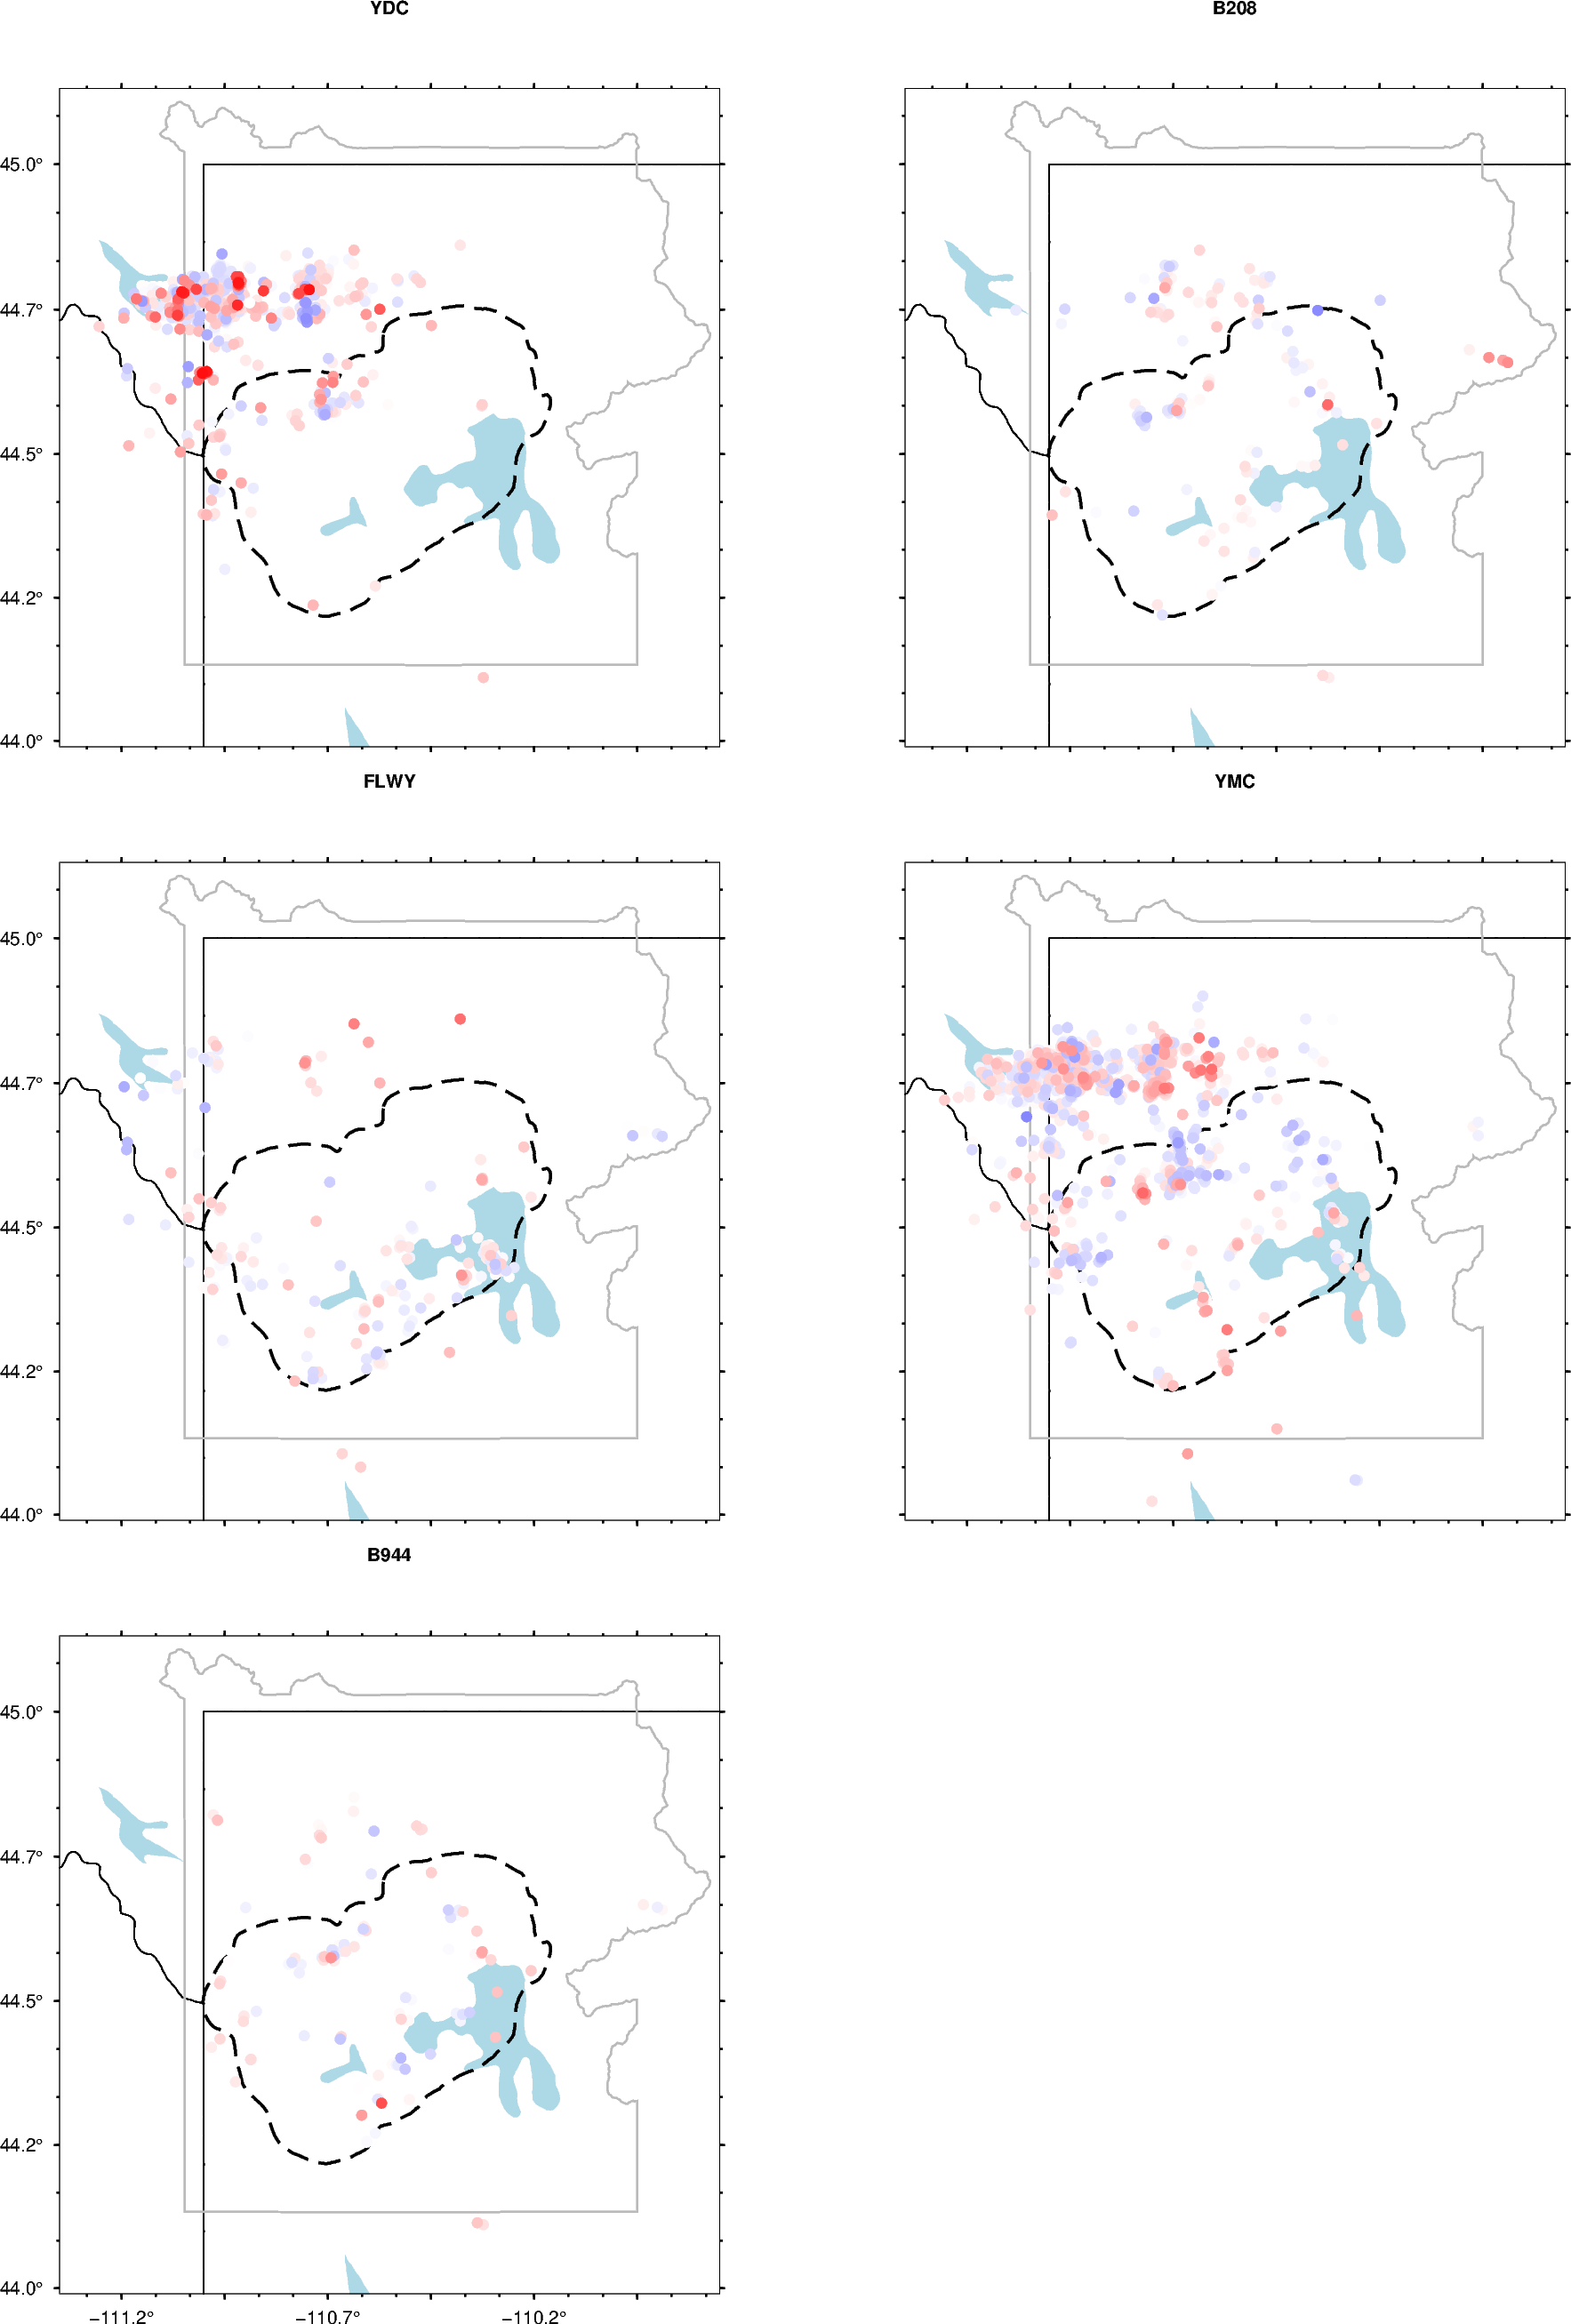

In [17]:
fig = pygmt.Figure()
pygmt.config(MAP_FRAME_TYPE="plain", MAP_FRAME_PEN="0.15p", MAP_TICK_LENGTH_PRIMARY="0.05c", 
                 FONT_TITLE="5p", FORMAT_GEO_MAP="ddd.x", FONT='5p')
pygmt.makecpt(cmap="polar", series=[-1.6, 1.6])
with fig.subplot(
    nrows=3,
    ncols=2,
    figsize=("15c", "21c"),
    sharex="b",
    sharey="l",
    region=STUDYREG, 
    margins="0.5c"
):
    for stat in p_results[p_results['test_r2'] < 0.85].station:
        print(stat)
        fig.coast(region=STUDYREG, projection='M?', water="lightblue", borders="2/0.3p", panel=True)
        fig.basemap(frame=[f'+t{stat}'])
        #
        # Plot utahnet boundaries
        #
        fig.plot(data=ys_border, pen='0.5p,#bababa') #,panel=True)
        fig.plot(data=caldera, pen='0.75p,black,-')

        #
        # Plot events
        #
        fig.plot(x=p_combined_preds[p_combined_preds['station'] == stat].source_longitude, 
            y=p_combined_preds[p_combined_preds['station'] == stat].source_latitude,
        style='c0.1c', fill=p_combined_preds[p_combined_preds['station'] == stat].residual, cmap=True)
        #fig.plot(data=p_train_df[p_train_df['station'] == stat][['source_longitude', 'source_latitude']], style='c0.2p', fill='black')

fig.show()

FLWY
YML
YTP
YMC
B950


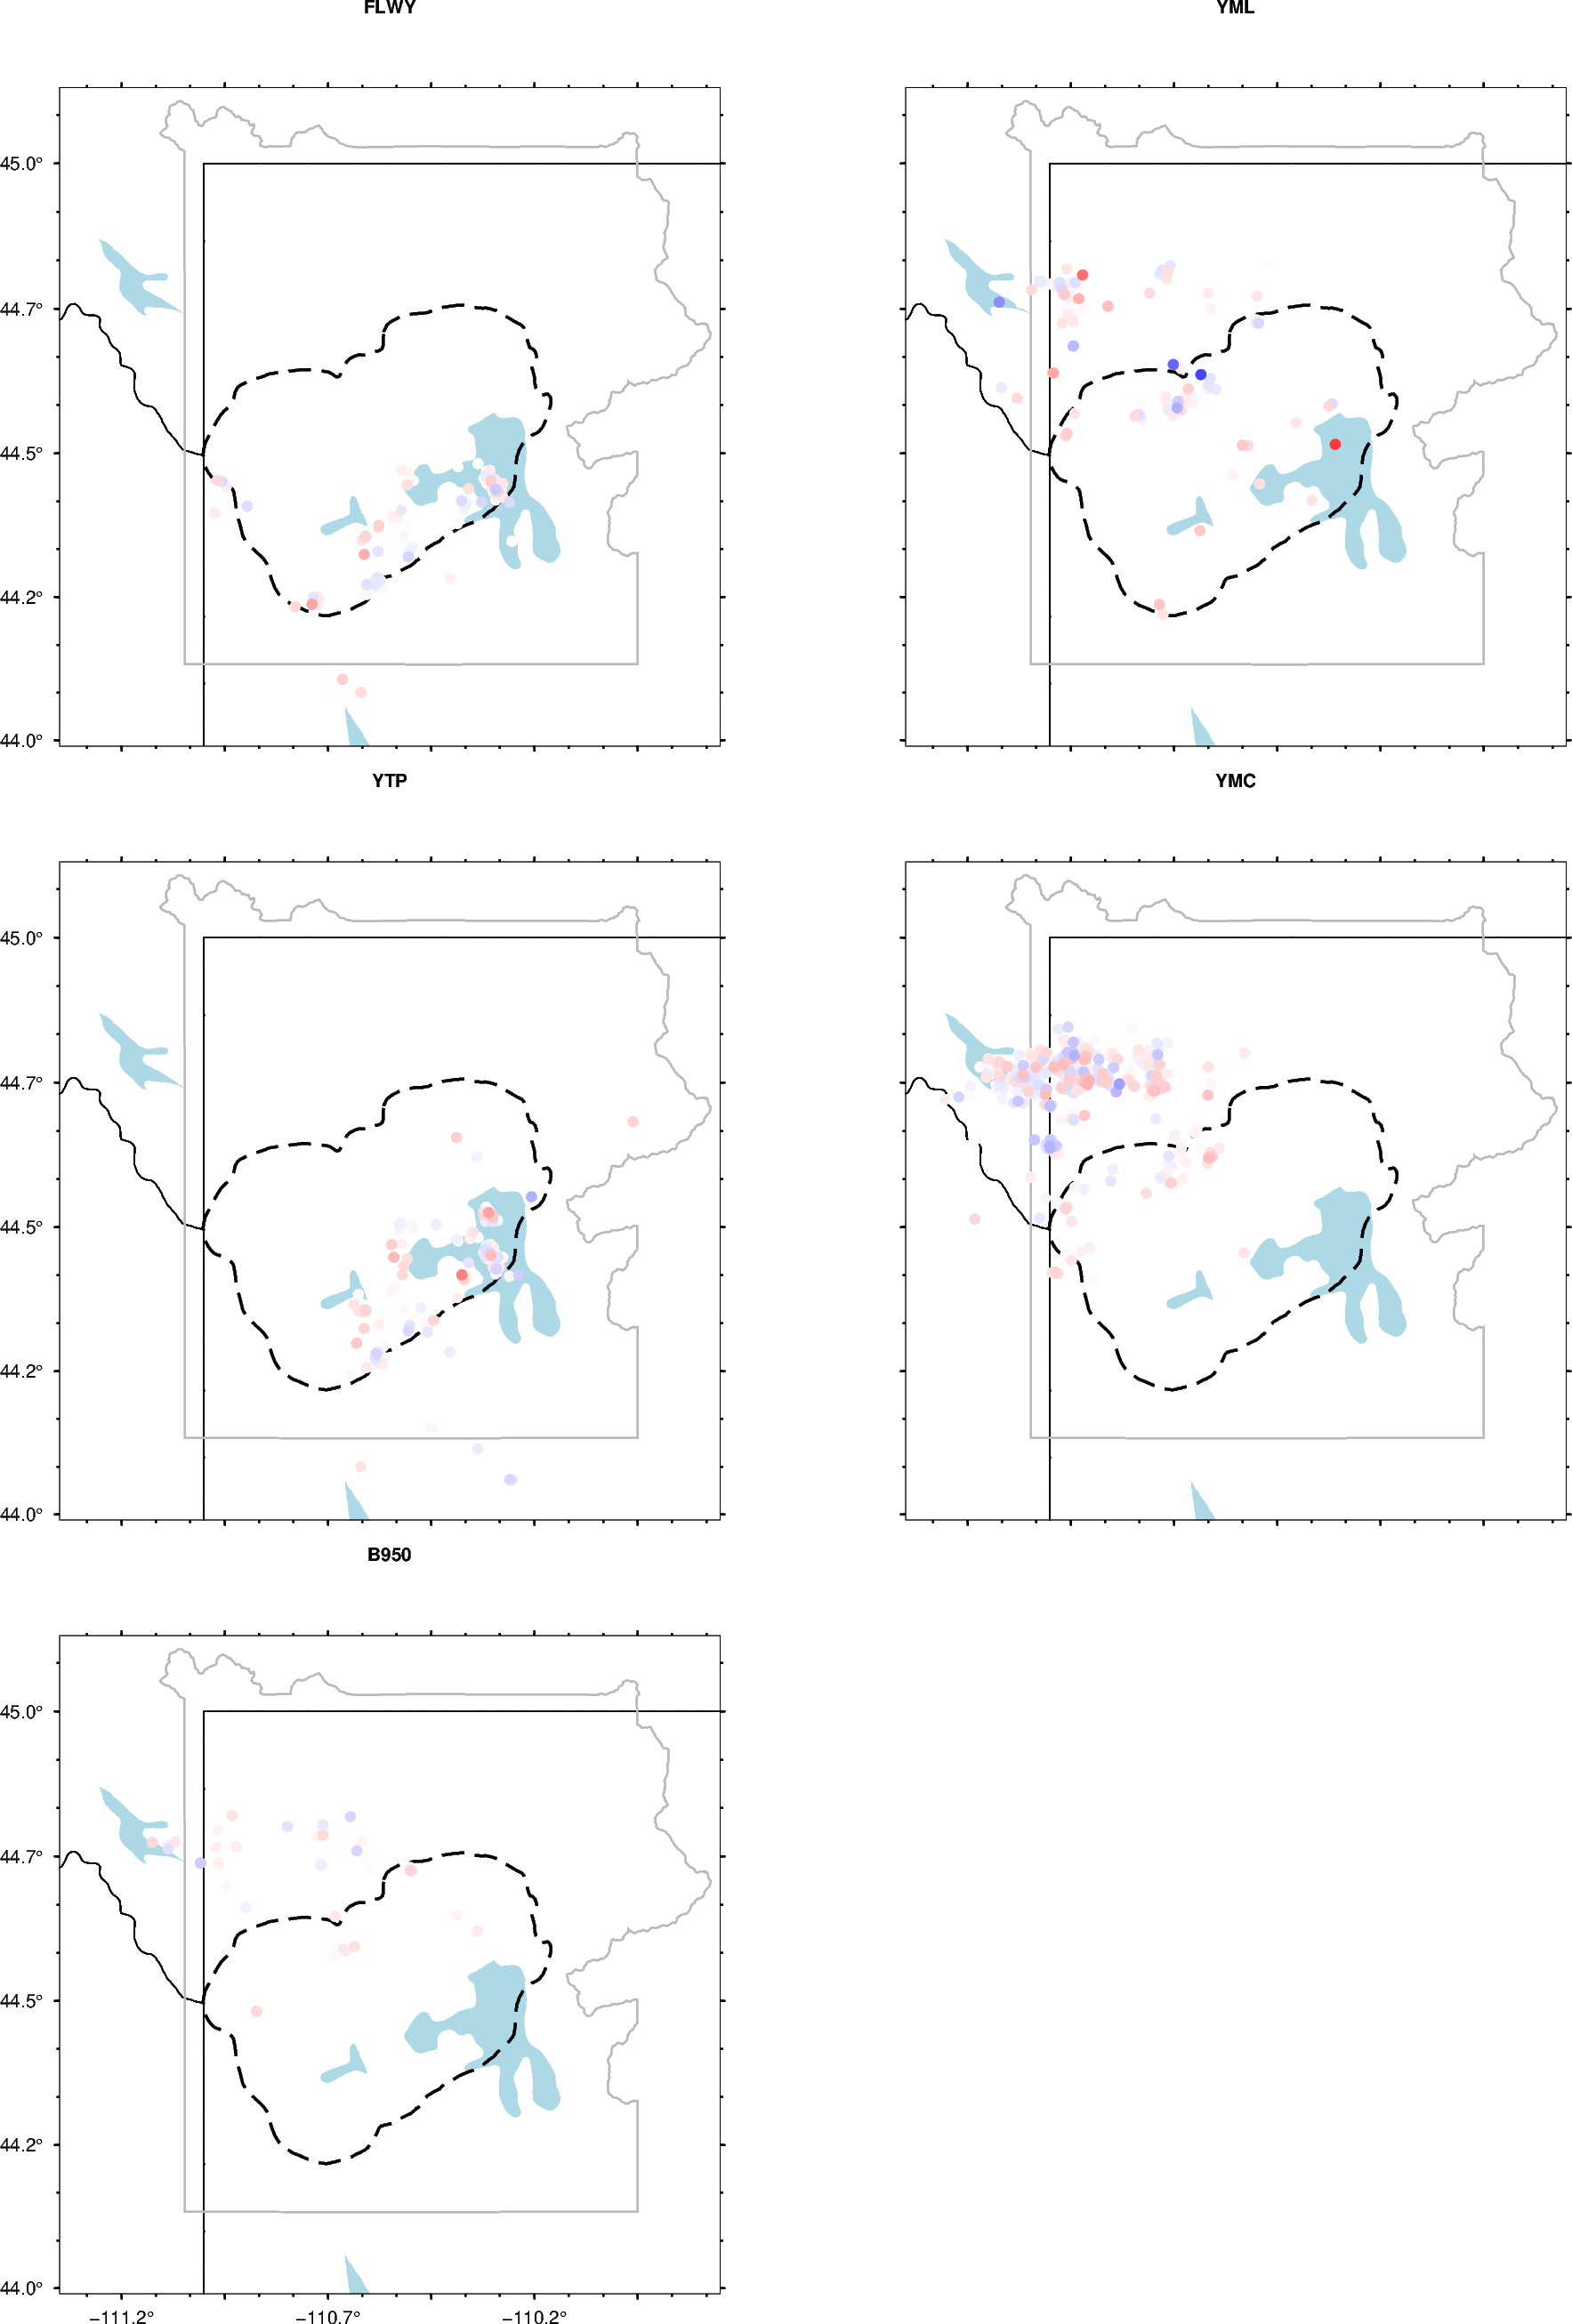

In [18]:
fig = pygmt.Figure()
pygmt.config(MAP_FRAME_TYPE="plain", MAP_FRAME_PEN="0.15p", MAP_TICK_LENGTH_PRIMARY="0.05c", 
                 FONT_TITLE="5p", FORMAT_GEO_MAP="ddd.x", FONT='5p')
pygmt.makecpt(cmap="polar", series=[-1.6, 1.6])
with fig.subplot(
    nrows=3,
    ncols=2,
    figsize=("15c", "21c"),
    sharex="b",
    sharey="l",
    region=STUDYREG, 
    margins="0.5c"
):
    for stat in s_results[s_results['test_r2'] < 0.85].station:
        print(stat)
        fig.coast(region=STUDYREG, projection='M', water="lightblue", borders="2/0.3p", panel=True)
        fig.basemap(frame=[f'+t{stat}'])
        #
        # Plot utahnet boundaries
        #
        fig.plot(data=ys_border, pen='0.5p,#bababa') #,panel=True)
        fig.plot(data=caldera, pen='0.75p,black,-')

        #
        # Plot events
        #
        fig.plot(x=s_combined_preds[s_combined_preds['station'] == stat].source_longitude, 
            y=s_combined_preds[s_combined_preds['station'] == stat].source_latitude,
        style='c0.1c', fill=s_combined_preds[s_combined_preds['station'] == stat].residual, cmap=True)
        #fig.plot(data=s_train_df[s_train_df['station'] == stat][['source_longitude', 'source_latitude']], style='c0.2p', fill='black')
fig.show()